# Project: Air Quality Prediction in Lombardy Region
---
**Name:** Kant Charoensedtasin (Gun)

# Background and Problem Statement
---
**Background**

The Lombardy region is one of the most polluted region in Europe. There is a large evidence that the agricultural section has a significant impact on air quality. The Lombardy region has several agicultural section then there are large amount of pollutants emitted to the air. The data scientists in the Lombardy region were assigned to build the model to predicting the pollutants quantity in the air. The model which predicted the pollutants in the air might help to decide the next actionable plan for balancing between agricultural products and air quality.

**Problem Statement**
- The data scientists were assign to build the time series model architecture for predicting each pollutants of each station in the Lombardy region.
- Identify the bad air quality days from the model and comparing to the actual value.
- Recommendation for improving the time series model

**Note** - Because the time series data has large fluctuation in the data, the model might be not good to capture all of the fluctuation in the data. So, the model in this project might be not that accuracy compare to normal regression problem.

# Data Preparation and Exploration Data Analysis
---

In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('bright')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import initializers

[Agrimonia_Dataset](https://zenodo.org/record/6620530#.Y1Fkf3bP1PY)
- [Air quality index](https://airindex.eea.europa.eu/Map/AQI/Viewer/#)
- [Air quality index2](https://www.euronews.com/weather/copernicus-air-quality-index)

## Data cleaning

In [328]:
df = pd.read_csv("./data/Agrimonia_Dataset.csv",low_memory=False)

In [329]:
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,NaN,NaN,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,NaN,NaN,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,NaN,NaN,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,NaN,NaN,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,NaN,NaN,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [330]:
# Check shape of the data set
df.shape

(309072, 41)

In [331]:
# Check type of the data set
df.dtypes

IDStations                      object
Latitude                       float64
Longitude                      float64
Time                            object
Altitude                         int64
AQ_pm10                         object
AQ_pm25                         object
AQ_co                           object
AQ_nh3                          object
AQ_nox                          object
AQ_no2                          object
AQ_so2                          object
WE_temp_2m                     float64
WE_wind_speed_10m_mean         float64
WE_wind_speed_10m_max          float64
WE_mode_wind_direction_10m      object
WE_tot_precipitation           float64
WE_precipication_t               int64
WE_surface_pressure            float64
WE_solar_radiation             float64
WE_rh_min                      float64
WE_rh_mean                     float64
WE_rh_max                      float64
WE_wind_speed_100m_mean        float64
WE_wind_speed_100m_max         float64
WE_mode_wind_direction_10

In [332]:
# Check missing value in the data set
df.isnull().sum()[df.isnull().sum() != 0]

LA_land_use      6576
LA_soil_use    160738
dtype: int64

In [333]:
# Select object columns
object_col = df.select_dtypes(include='object').columns
object_col

Index(['IDStations', 'Time', 'AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox',
       'AQ_no2', 'AQ_so2', 'WE_mode_wind_direction_10m',
       'WE_mode_wind_direction_100m', 'EM_nh3_livestock_mm',
       'EM_nh3_agr_soils', 'EM_nh3_agr_waste_burn', 'EM_nh3_sum',
       'EM_nox_traffic', 'EM_nox_sum', 'EM_so2_sum', 'LI_pigs', 'LI_bovine'],
      dtype='object')

In [334]:
# `NaN` in the air quality columns is imputed the value 
# which is noise of the data.
aq_col = ['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3',
          'AQ_nox', 'AQ_no2', 'AQ_so2']
for col in list(aq_col):
    print(f"Missing value 'NaN' in column {col}: {df[col].str.contains('NaN').sum()}")

Missing value 'NaN' in column AQ_pm10: 89634
Missing value 'NaN' in column AQ_pm25: 208379
Missing value 'NaN' in column AQ_co: 197180
Missing value 'NaN' in column AQ_nh3: 292617
Missing value 'NaN' in column AQ_nox: 107843
Missing value 'NaN' in column AQ_no2: 49132
Missing value 'NaN' in column AQ_so2: 227026


In [335]:
# Remove space of `NaN` value in dataframe
df = df.replace('\s+','',regex=True)

In [336]:
# Impute missing all `NaN` value with 0
df = df.replace('NaN',0)
df = df.fillna(0)
df.head()

,IDStations,Latitude,Longitude,Time,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
0,1264,46.167852,9.87921,2016-01-01,290,6.200e+01,5.300e+01,0,0,8.263e+01,...,6.166e-01,8.359e-01,1.720e+00,3.906e-01,3.832e-01,5.892e+00,3.998,1.234,112.0,17.0
1,1264,46.167852,9.87921,2016-01-02,290,7.300e+01,6.300e+01,0,0,1.017e+02,...,6.298e-01,8.372e-01,1.720e+00,3.911e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
2,1264,46.167852,9.87921,2016-01-03,290,4.400e+01,3.900e+01,0,0,6.626e+01,...,6.424e-01,8.384e-01,1.720e+00,3.916e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
3,1264,46.167852,9.87921,2016-01-04,290,3.100e+01,2.900e+01,0,0,6.331e+01,...,6.545e-01,8.396e-01,1.720e+00,3.923e-01,3.832e-01,5.892e+00,3.997,1.234,112.0,17.0
4,1264,46.167852,9.87921,2016-01-05,290,2.700e+01,2.600e+01,0,0,7.553e+01,...,6.660e-01,8.409e-01,1.720e+00,3.931e-01,3.832e-01,5.892e+00,3.997,1.233,112.0,17.0


In [337]:
# Convert object column except 'IDStations', 'Time','WE_mode_wind_direction_10m' and, 
# 'WE_mode_wind_direction_100m' columns to float
to_float_col = df.select_dtypes(include='object').drop(columns=['IDStations', 'Time',
                 'WE_mode_wind_direction_10m', 
                 'WE_mode_wind_direction_100m']).columns
for col in to_float_col:
    df[col] = df[col].astype(float)
df[to_float_col].dtypes

AQ_pm10                  float64
AQ_pm25                  float64
AQ_co                    float64
AQ_nh3                   float64
AQ_nox                   float64
AQ_no2                   float64
AQ_so2                   float64
EM_nh3_livestock_mm      float64
EM_nh3_agr_soils         float64
EM_nh3_agr_waste_burn    float64
EM_nh3_sum               float64
EM_nox_traffic           float64
EM_nox_sum               float64
EM_so2_sum               float64
LI_pigs                  float64
LI_bovine                float64
dtype: object

In [338]:
# Number of row that have value of 0
(df == 0).sum()[(df == 0).sum() != 0]

AQ_pm10                   90053
AQ_pm25                  208699
AQ_co                    197297
AQ_nh3                   293053
AQ_nox                   107843
AQ_no2                    49136
AQ_so2                   227037
WE_tot_precipitation      10224
WE_precipication_t       213689
EM_nh3_livestock_mm       51465
EM_nh3_agr_soils          51465
EM_nh3_agr_waste_burn     54492
EM_nh3_sum                51465
EM_nox_traffic            51465
EM_nox_sum                51465
EM_so2_sum                51465
LI_pigs                   45714
LI_bovine                 24674
LA_land_use                6576
LA_soil_use              173478
dtype: int64

In [339]:
df['IDStations'].nunique()

141

In [340]:
df['Time'] = pd.to_datetime(df['Time'])

In [341]:
# df.describe().round(2).T[['mean','std','min','50%','max']]

In [342]:
# Convert `WE_surface_pressure` and `WE_solar_radiation` unit
# to MPa and MJ/m^2 respectively
# Divided the value in this 2 columns by 100_000
# Purpose: change the scale of the data
df['WE_surface_pressure'] = df['WE_surface_pressure']/100_000
df['WE_solar_radiation'] = df['WE_solar_radiation']/100_000

In [343]:
df_time_index = df.copy()

In [344]:
# Set time to index
df_time_index.set_index('Time',inplace=True)

In [345]:
df_time_index.head(1)

,IDStations,Latitude,Longitude,Altitude,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,...,EM_nh3_sum,EM_nox_traffic,EM_nox_sum,EM_so2_sum,LI_pigs,LI_bovine,LA_hvi,LA_lvi,LA_land_use,LA_soil_use
Time,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1264,46.167852,9.87921,290,62.0,53.0,0.0,0.0,82.63,37.72,...,0.6166,0.8359,1.72,0.3906,0.3832,5.892,3.998,1.234,112.0,17.0


## Exploration Data Analysis

In [346]:
aq_col = df.columns[df.columns.str.contains('AQ')]
aq_col

Index(['AQ_pm10', 'AQ_pm25', 'AQ_co', 'AQ_nh3', 'AQ_nox', 'AQ_no2', 'AQ_so2'], dtype='object')

In [347]:
overall_station_polltion = df.groupby(['IDStations']).mean()[aq_col].round(2)
overall_station_polltion.head()

,AQ_pm10,AQ_pm25,AQ_co,AQ_nh3,AQ_nox,AQ_no2,AQ_so2
IDStations,,,,,,,
1264,21.57,17.25,0.00,0.00,37.46,18.59,0.0
1265,30.33,23.19,0.00,0.00,53.01,28.62,0.0
1266,30.49,0.00,0.00,29.57,37.90,22.44,0.0
1269,27.94,22.85,0.48,0.00,49.31,27.57,0.0
1274,0.00,0.00,0.00,0.00,20.64,15.20,0.0


In [348]:
def top5_pollution(quality):
    """Filter 5 station that have high quanty of pollutants"""
    return overall_station_polltion.sort_values(f'AQ_{quality}',ascending=False)\
[[f'AQ_{quality}']].head()

In [349]:
def extract_aq_df(quality, station):
    """Filter dataframe which contain the value of air quality in the given station
    -------
    Parameter: quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               station e.g. '652', 'STA.IT1509A'
    """
    df = df_time_index[df_time_index[f'AQ_{quality}'] != 0]\
    [df_time_index[df_time_index[f'AQ_{quality}'] != 0]['IDStations'] == station]
    return df

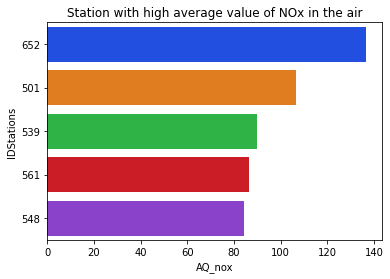

In [350]:
# 5 station that have highest overall amount of NOx in the air
sns.barplot(y=top5_pollution('nox').index, x = 'AQ_nox',data = top5_pollution('nox'))
plt.title('Station with high average value of NOx in the air');

In [351]:
extract_aq_df('nox','652')['AQ_nox'].describe()

count    2157.000000
mean      138.870283
std        82.061550
min        10.610000
25%        80.140000
50%       115.200000
75%       179.700000
max       554.400000
Name: AQ_nox, dtype: float64

In [352]:
extract_aq_df('nox','652')['AQ_nox'].skew()

1.2970630667223808

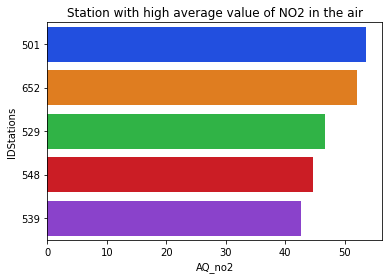

In [353]:
# 5 station that have highest overall amount of NO2 in the air
sns.barplot(y=top5_pollution('no2').index, x = 'AQ_no2',data = top5_pollution('no2'))
plt.title('Station with high average value of NO2 in the air');

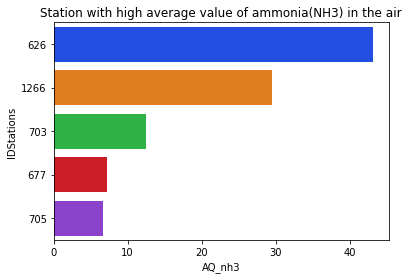

In [354]:
# 5 station that have highest overall amount of NH3 in the air
sns.barplot(y=top5_pollution('nh3').index, x = 'AQ_nh3',data = top5_pollution('nh3'))
plt.title('Station with high average value of ammonia(NH3) in the air');

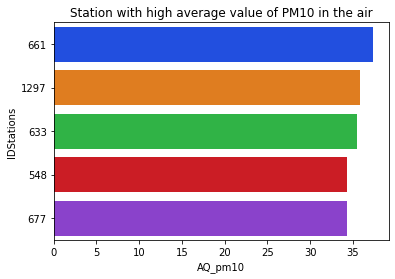

In [355]:
# 5 station that have highest overall amount of pm10 in the air
sns.barplot(y=top5_pollution('pm10').index, x = 'AQ_pm10',data = top5_pollution('pm10'))
plt.title('Station with high average value of PM10 in the air');

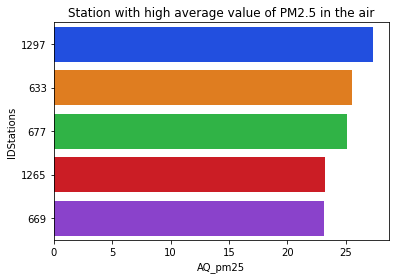

In [356]:
# 5 station that have highest overall amount of pm2.5 in the air
sns.barplot(y=top5_pollution('pm25').index, x = 'AQ_pm25',data = top5_pollution('pm25'))
plt.title('Station with high average value of PM2.5 in the air');

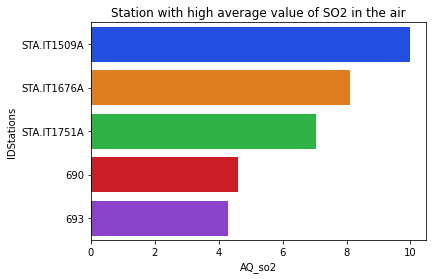

In [357]:
# 5 station that have highest overall amount of SO2 in the air
sns.barplot(y=top5_pollution('so2').index, x = 'AQ_so2',data = top5_pollution('so2'))
plt.title('Station with high average value of SO2 in the air');

In [358]:
# Most station for each air pollution
most_pollution = pd.DataFrame(columns=['IDStations', 'quality', 'Values'])
for i, quality in enumerate(['nox','no2','nh3','pm10','pm25','so2']):
    most_pol_temp = top5_pollution(quality).head(1)
    most_pollution.loc[i] = [most_pol_temp.index[0], quality, most_pol_temp.values[0][0]]

In [359]:
most_pollution

,IDStations,quality,Values
0,652,nox,136.65
1,501,no2,53.63
2,626,nh3,43.11
3,661,pm10,37.31
4,1297,pm25,27.29
5,STA.IT1509A,so2,9.98


We got the stations which have the most pollution in each air pollution quality, then we decided to select this station for modeling and predicting the air quality. In this project, we choose only 1 station for each air quality. The model we build in this project might be the model architecture for the future project.

**In summary**, we choose station for each pollutants following the analysis in the EDA section.
- Station: 652 for air quality of NO$_{x}$
- Station: 501 for air quality of NO$_{2}$
- Station: 626 for air quality of NH$_{3}$
- Station: 661 for air quality of PM$_{10}$
- Station: 1297 for air quality of PM$_{2.5}$
- Station: STA.IT1509A for air quality of SO$_{2}$

# Modeling and Model evaluation
---
In the modeling and model evaluation section, we used the ordinary time series model which is ARIMA model and advance model such as recurrent neural network model (RNN) and Long short-term memory model (LSTM). This section contains 7 parts.
1. Function using in the modeling section
2. Model for predicting nitrogen oxide (NO$_{x}$) quantity of station 652
3. Model for predicting nitrogen dioxide (NO$_{2}$) quantity of station 501
4. Model for predicting ammonia (NH$_{3}$) quantity of station 626
5. Model for predicting PM$_{10}$ of station 661
6. Model for predicting PM$_{2.5}$ of station 1297
7. Model for predicting sulfur dioxide (SO$_{2}$) quantity of station STA.IT1509A

The modeling parts will have at least 3 models which are ARIMA, RNN and LSTM model. The train and test data of ARIMA and neural network model will split in the different method.
- For ARIMA model, The test data will be the small size (~5% of the data) because ARIMA model will predict the mean of the data in the long term.
- For RNN and LSTM model, The test data will be the default size of the split in the Scikit-learn (25% of the data).
- The last model for each pollutants may be the RNN or LSTM model and do feature engineering in the model. The feature engineering in this modeling part is dummying the categorical variable and adding the moving average.

The evaluation of the model will be one or more of the below list.
- Score of the model: Mean square error, Akaike Information Critera (for ARIMA model)
- Ablity for capture the trend in the time series data observed by time series graph

## Function using in the modeling section
This part is gathering the function using in the modeling section.
1. Function using for extract/visualize the data
2. Function using in the ARIMA model

### Function using for extract/visualize the data

In [360]:
def station_daily(station, quality, label):
    """Display daily air quality of the given station
    -------
    Parameter: station e.g. '652', 'STA.IT1509A'
               quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               label: label of y axis
    """
    plt.figure(figsize=(15,6))
    df_temp = extract_aq_df(quality,station)
    plt.plot(df_temp[f'AQ_{quality}'], color='royalblue')
    plt.title(f'Daily {label} quantity of station {station}',fontsize=18)
    plt.ylabel(label, fontsize=15)
    plt.xlabel('Time', fontsize=15)
    plt.axhline(df_temp[f'AQ_{quality}'].mean(),color='salmon');

### Function using in the ARIMA model

In [361]:
def interpret_dftest(dftest):
    """Check for stationary of the time series data
    -------
    Parameter: Adfuller of extracted dataframe
    Return: Dataframe with Test statistic and p-value
    """
    dfoutput = pd.Series(dftest[0:2], 
                         index=['Test Statistic','p-value'])
    return dfoutput

In [362]:
def train_test_time_series(station, quality,test_size=0.1):
    """Split the data for statistic model e.g. ARIMA
    -------
    Parameter: station e.g. '652', 'STA.IT1509A'
               quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
               test_size: float 0 to 1 with default=0.1
    Return: train, test
    """
    train, test = train_test_split(extract_aq_df(quality,station)[f'AQ_{quality}'],
                                       test_size=test_size,
                                       shuffle=False)
    # Assign frequency of data
    train.index = train.index.to_period('d')
    test.index = test.index.to_period('d')
    return train, test

In [363]:
def fit_preds(stat_model, test, show_aic=True, show_mse=True):
    """Fit and Predict value from statistic model e.g. ARIMA
    -------
    Parameter:  stat_model: Instantiate statistic model
                test: test set data 
                show_aic: bool print Akaike Information Critera with default = True
                show_mse: bool print Mean Square Error with default = True
    Return: preds, model.aic, mean_squared_error(test, preds)
    """
    model = stat_model.fit()
    # preds = model.predict(start=train.shape[0], end=(train.shape[0]+test.shape[0]-1))
    preds = model.predict(start=test.index[0], end=test.index[-1])
    if show_aic:
        print(f'AIC: {model.aic}')
    if show_mse:
        print(f'MSE: {mean_squared_error(test, preds)}')
    return preds, model.aic, mean_squared_error(test, preds)

In [364]:
def manual_gridsearch(p_list, d_list, q_list):
    """GridSearch the ARIMA model
    -------
    Parameter:  p, d, q list for gridsearch
    Return: result dataframe from gridsearch
    """
    manual_grid = pd.DataFrame(columns=['p','d','q','aic','mse'])
    count = 0
    for p in p_list:
        for d in d_list:
            for q in q_list:
                ar1 = ARIMA(endog=train, order=(p,d,q))
                preds, aic, mse = fit_preds(ar1, test,show_mse=False,show_aic=False)
                manual_grid.loc[count] = [p, d, q, aic, mse]
                count += 1
    return manual_grid

In [365]:
def station_arima_graph(train, test, preds, quality_title, station):
    """Compare train, test and prediction from ARIMA model
    -------
    Parameter: train: train set
               test: test set
               preds: prediction set
               quality_title: title showing in the title
               station e.g. '652', 'STA.IT1509A'
    """
    plt.figure(figsize=(15,6))

    # Plot training data in blue.
    #plt.plot(train, color = 'royalblue')
    sns.lineplot(x=train.index.to_timestamp(), y=train, color = 'royalblue',label='train')

    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange',label='test')

    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green',label='predict')

    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend()
    plt.show();

In [366]:
def test_pred_graph(test, preds, quality_title, station):
    """Compare test and prediction from ARIMA model
    -------
    Parameter: test: test set
               preds: prediction set
               quality_title: title showing in the title
               station e.g. '652', 'STA.IT1509A'
    """
    plt.figure(figsize=(10,6))
    
    # Plot testing data in orange.
    sns.lineplot(x=test.index.to_timestamp(), y=test, color = 'orange', label='test')
    
    # Plot predicted values in green.
    sns.lineplot(x=preds.index.to_timestamp(), y=preds, color = 'green', label='predict')
    
    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.legend()
    plt.show();

### Function using in Recurrent Neural Network (RNN) and Long Short-Term memory (LSTM) model

In [367]:
def extract_split(quality, station):
    """Extract dataframe from given condition, define X and y for using in the model and split X and y.
    Note - The extracted dataframe contain only numeric columns.
    Parameter:  quality: 'nox', 'no2', 'nh3', 'pm10', 'pm25', 'so2'
                station e.g. '652', 'STA.IT1509A'
    Return: X_train, X_test, y_train, y_test
    """
    data = extract_aq_df(quality,station)
    drop_cols = ['Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
     'AQ_nox','AQ_no2','AQ_so2']
    X = data.select_dtypes(exclude = 'object').drop(columns=drop_cols)
    y = data[f'AQ_{quality}']
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        shuffle=False)
    return X_train, X_test, y_train, y_test

In [368]:
def scale_sequences(X_train, X_test, y_train, y_test, length=3):
    """Scale and transform X, y to sequences
    Parameter:  split data: X_train, X_test, y_train, y_test
                length: default = 3
    Return: train_sequences, test_sequences, input_shape
    """
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)

    # Using TimeseriesGenerator to transform the data
    train_sequences = TimeseriesGenerator(X_train_sc, y_train, length=length, batch_size=64)
    test_sequences = TimeseriesGenerator(X_test_sc, y_test,
                                        length=length, batch_size=64)
    input_shape = train_sequences[0][0][0].shape
    return train_sequences, test_sequences, input_shape

In [369]:
def compile_fit(model, learning_rate, train_sequences, test_sequences, n_epoch, callbacks,
                verbose=0):
    """Compile and fit neural network model e.g. RNN and LSTM model.
    -------
    Parameter:  model: Instantiate RNN or LSTM model
                train_sequences, test_sequences: train and test sequence 
                n_epoch: Number of epochs
                callbacks: Callback method e.g. earlystopping
                verbose: default = 'auto'
    Return: model, history
    """
    model.compile(loss='mse',optimizer=Adam(learning_rate=learning_rate))
    history = model.fit(train_sequences, validation_data=test_sequences,
                        epochs=n_epoch, callbacks=[callbacks], verbose=verbose)
    return model, history

In [370]:
def loss_graph():
    """Plot model loss"""
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('epochs')
    plt.legend();

In [371]:
def nn_result_graph(quality_title, station, aqi=None, length=3, color='red'):
    """Plot model time series with train, test, predict data
    -------
    Parameter:  quality_title: title showing in the title
                station e.g. '652', 'STA.IT1509A'
                aqi: In case needed to compare to aqi data default = None
                length: parameter from tranforming to sequences default = 3
                color: color of aqi line default = 'red'
    """
    plt.figure(figsize=(15,6))
    sns.lineplot(x=X_train.index, y=y_train, label='train')
    sns.lineplot(x=X_test.index, y=y_test, label='test')
    sns.lineplot(x=X_test.index[length:], y=y_preds[:,0], label='predict')
    plt.title(f'{quality_title} quantity of station {station}',fontsize=18)
    plt.ylabel(quality_title, fontsize=12)
    plt.xlabel('Time', fontsize=12)
    plt.legend()
    if aqi != None:
        plt.axhline(aqi,color=color);

In [372]:
def model_error(length=3):
    """MSE, MAPE of training and testing"""
    print(f'Training loss: {round(model.evaluate(train_sequences, verbose=0),2)}')
    print(f'Testing loss: {round(model.evaluate(test_sequences, verbose=0),2)}')
    print(f'MAPE: {round(mean_absolute_percentage_error(y_test[length:],y_preds)*100,2)}')

## Model for predicting nitrogen oxide (NO$_{x}$) quantity of station 652

### ARIMA model

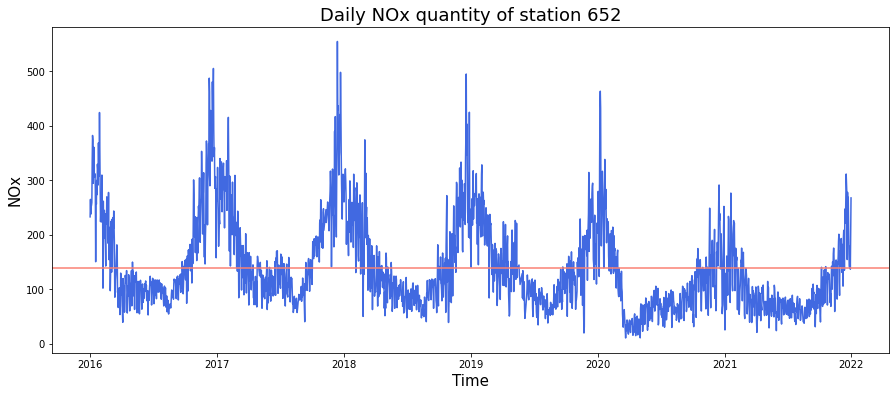

In [373]:
# NOx quantity of station 652
station_daily(station ='652',
              quality='nox',
              label='NOx')

Autocorrelation additional information: 
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/autocorrelation/interpret-the-results/autocorrelation-function-acf/m
- https://www.influxdata.com/blog/autocorrelation-in-time-series-data/

Parial Autocorrelation additional information:
- https://support.minitab.com/en-us/minitab/21/help-and-how-to/statistical-modeling/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/

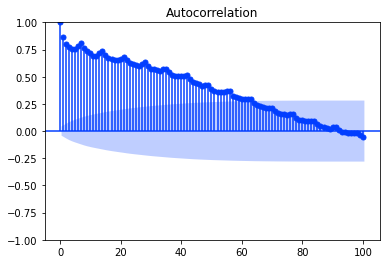

In [374]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=100);

(0.0, 20.0)

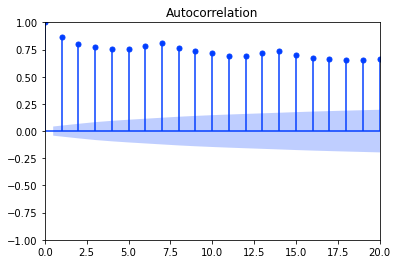

In [375]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nox','652')['AQ_nox'],lags=400);
plt.xlim(0,20)

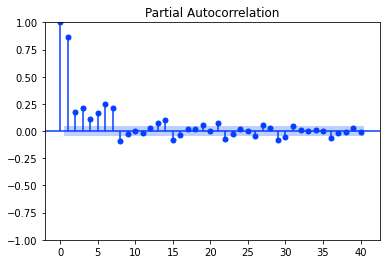

In [376]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('nox','652')['AQ_nox'],lags=40, method='ywm');

In [377]:
# adfuller for checking the trend of station's 652 data
interpret_dftest(adfuller(extract_aq_df('nox','652')['AQ_nox'].dropna()))
# No trend

Test Statistic   -3.447531
p-value           0.009441
dtype: float64

In [378]:
train, test = train_test_time_series('652', 'nox',test_size=0.05) 

In [379]:
type(train)

pandas.core.series.Series

In [380]:
train.shape, test.shape

((2049,), (108,))

In [381]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(10,0,10))
preds, aic, mse = fit_preds(ar1, test)

AIC: 20426.190557941904
MSE: 3249.735923551522


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


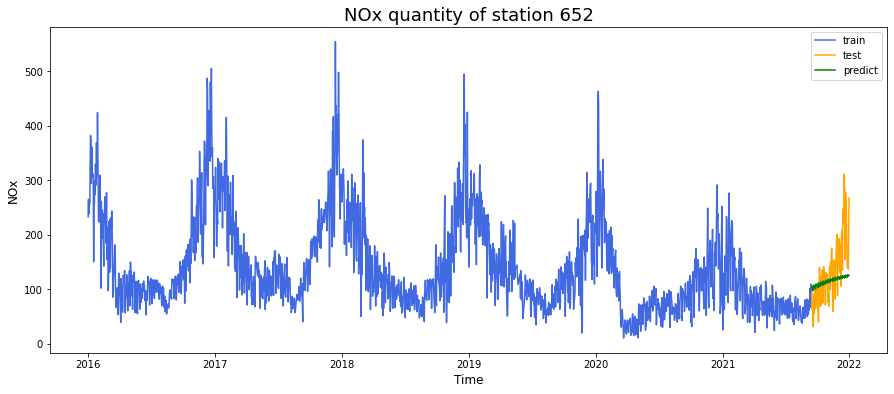

In [382]:
station_arima_graph(train, test, preds,'NOx','652')

In [383]:
# Manual Gridsearch
# p_list = [p for p in range(6,10)]
# d_list = [0, 1]
# q_list = [q for q in range(6,10)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/nox_arima_gridsearch.csv',index=False)

In [384]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/nox_arima_gridsearch.csv')

In [385]:
manual_grid.sort_values('mse').head()

,p,d,q,aic,mse
18,8.0,0.0,8.0,20421.192271,3131.433324
26,9.0,0.0,8.0,20425.767966,3134.724902
27,9.0,0.0,9.0,20422.122378,3316.109884
0,6.0,0.0,6.0,20470.080954,3351.673203
9,7.0,0.0,7.0,20456.101769,3450.973592


In [386]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,8))
preds, aic, mse = fit_preds(ar1, test)
mean_absolute_percentage_error(test, preds)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 20421.192271111875
MSE: 3131.433323838929


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0.3151907297361658

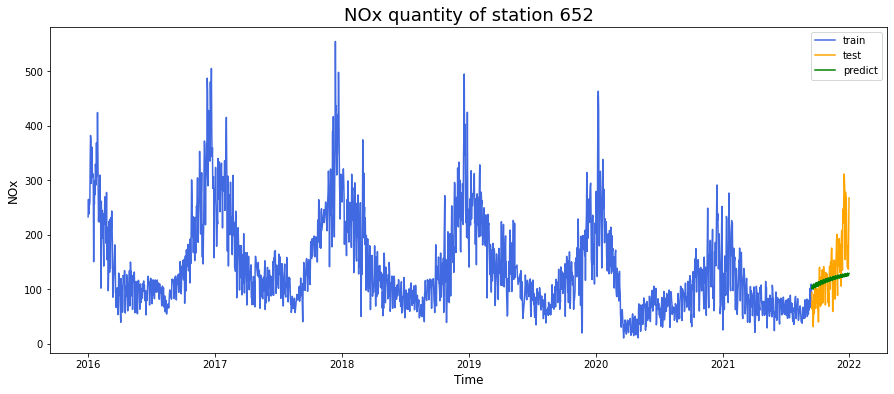

In [387]:
station_arima_graph(train, test, preds,'NOx','652')

### RNN model

In [388]:
X_train, X_test, y_train, y_test = extract_split('nox', '652')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [389]:
# Design RNN
es = EarlyStopping(patience=3)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

In [390]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 6166.28
Testing loss: 2164.58
MAPE: 38.69


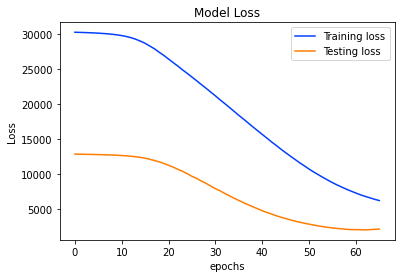

In [391]:
loss_graph()
model_error()

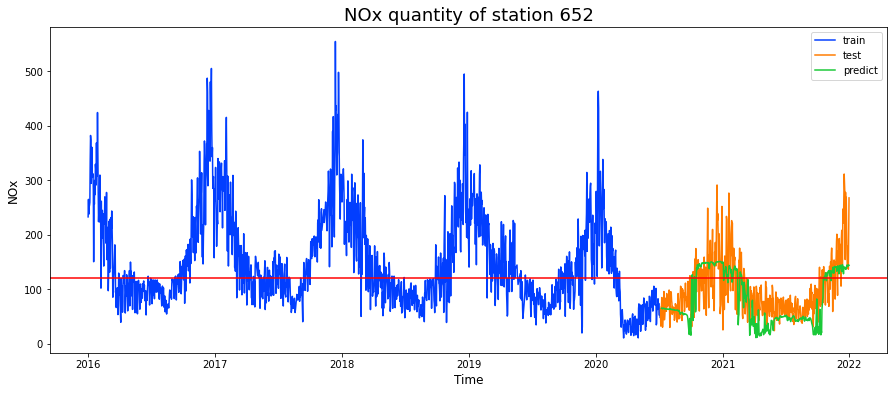

In [392]:
nn_result_graph('NOx', '652', aqi=120)

In [394]:
y_preds.shape, y_test.shape

((537, 1), (540,))

In [395]:
# Check amount of days that have nox in air quality > 120
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
poor_nox = performance[performance['AQ_nox'] > 120].copy()
poor_nox['pred_poor'] = (poor_nox['pred'] > 120).astype(int)
poor_nox.head()

,AQ_nox,pred,pred_poor
Time,,,
2020-09-29,124.9,17.263943,0
2020-10-08,132.2,42.666042,0
2020-10-13,155.4,117.243919,0
2020-10-14,121.8,111.317497,0
2020-10-15,146.2,58.511234,0


In [396]:
print(f"Predict NOx > 120: {round(poor_nox['pred_poor'].sum()/poor_nox.shape[0]*100,2)}%")

Predict NOx > 120: 83.01%


### LSTM model
- [LSTM Example](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
- **ELU activation** is very similiar to RELU except negative inputs. They are both in identity function form for non-negative inputs. On the other hand, ELU becomes smooth slowly until its output equal to -α whereas RELU sharply smoothes. [[Ref.]](https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#:~:text=ELU%20is%20very%20similiar%20to,%CE%B1%20whereas%20RELU%20sharply%20smoothes.&text=Pros-,ELU%20becomes%20smooth%20slowly%20until%20its%20output%20equal,%CE%B1%20whereas%20RELU%20sharply%20smoothes.)

In [397]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             100, es)

In [398]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 3113.84
Testing loss: 2054.04
MAPE: 37.18


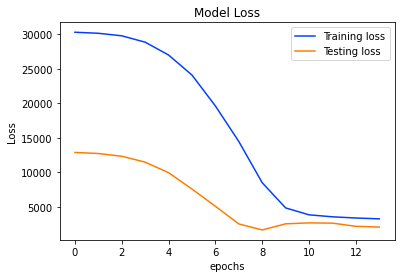

In [399]:
loss_graph()
model_error()

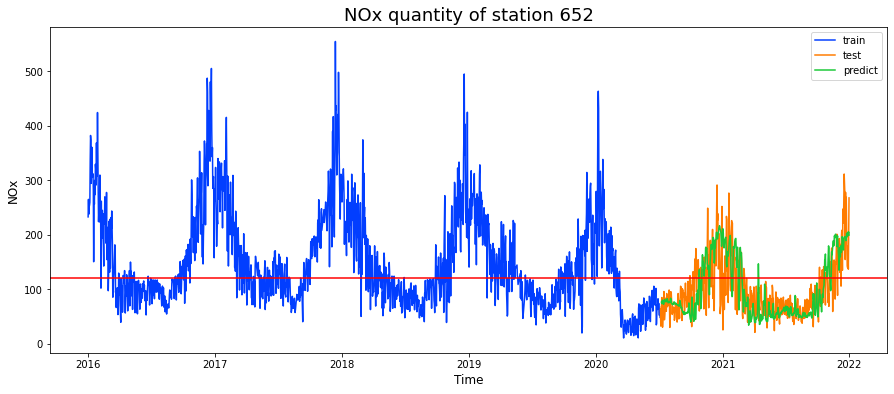

In [400]:
nn_result_graph('NOx', '652', aqi=120)

In [402]:
# Check amount of days that have nox in air quality > 120
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
poor_nox = performance[performance['AQ_nox'] > 120].copy()
poor_nox['pred_poor'] = (poor_nox['pred'] > 120).astype(int)
poor_nox.head()

,AQ_nox,pred,pred_poor
Time,,,
2020-09-29,124.9,48.692661,0
2020-10-08,132.2,47.828629,0
2020-10-13,155.4,69.259079,0
2020-10-14,121.8,74.492287,0
2020-10-15,146.2,44.618435,0


In [403]:
print(f"Predict NOx > 120: {round(poor_nox['pred_poor'].sum()/poor_nox.shape[0]*100,2)}%")

Predict NOx > 120: 77.78%


### LSTM model with feature engineering

In [404]:
df.select_dtypes(include='object').columns

Index(['IDStations', 'WE_mode_wind_direction_10m',
       'WE_mode_wind_direction_100m'],
      dtype='object')

In [439]:
data = extract_aq_df('nox','652')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling12_nox'] = data['AQ_nox'].rolling(window=12).mean()
data['rolling26_nox'] = data['AQ_nox'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_nox']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [440]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [441]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             100, es)

In [442]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 2571.24
Testing loss: 1764.0
MAPE: 34.56


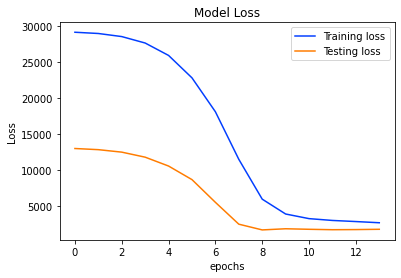

In [443]:
loss_graph()
model_error()

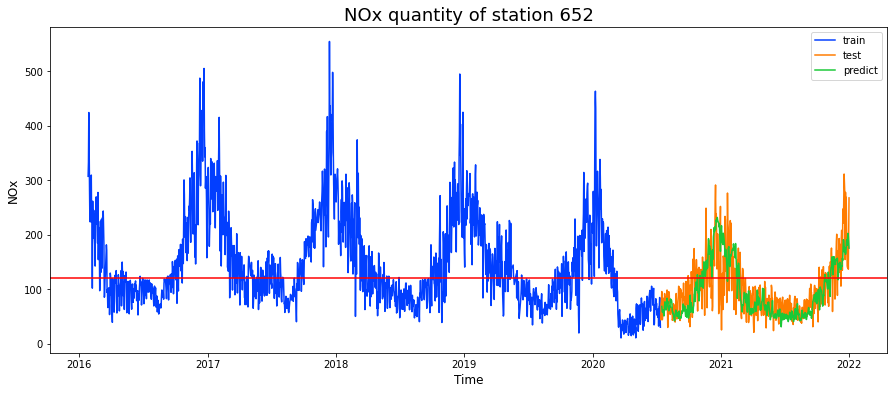

In [444]:
nn_result_graph('NOx', '652', aqi=120)

### Summary model for air quality: NO$_{x}$
The days have NO$_{x}$ quantity > 120 (Poor air quality):
- Both RNN and LSTM model can capture the trend of the time series data.

## Model for predicting nitrogen dioxide (NO$_{2}$) quantity of station 501

### ARIMA model

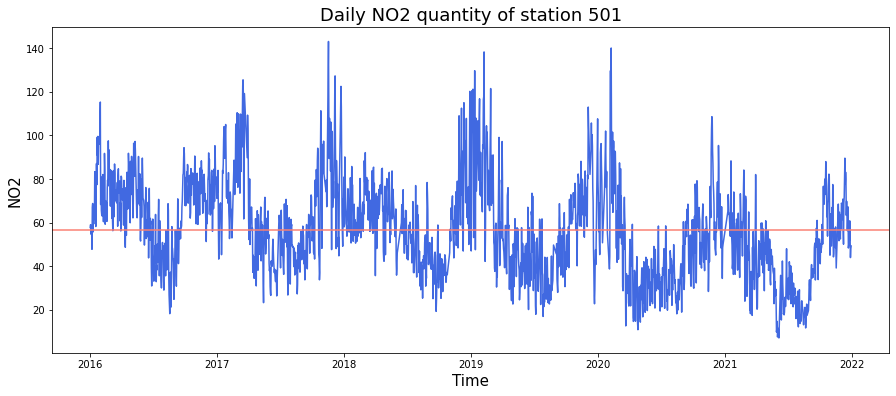

In [87]:
station_daily(station ='501',
              quality='no2',
              label='NO2')

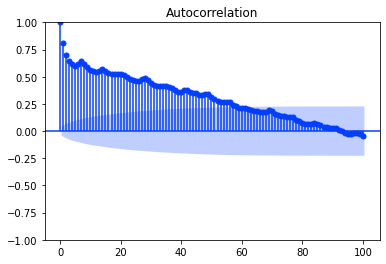

In [88]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('no2','501')['AQ_no2'],lags=100);

(0.0, 20.0)

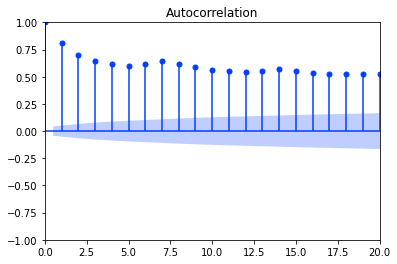

In [89]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('no2','501')['AQ_no2'],lags=400);
plt.xlim(0,20)

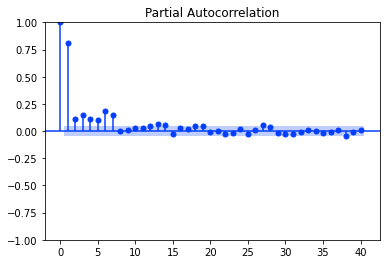

In [90]:
# Check seasonality by using acf and pacf
plot_pacf(extract_aq_df('no2','501')['AQ_no2'],lags=40,method='ywm');

In [91]:
# adfuller for checking the trend of station's 501 data
interpret_dftest(adfuller(extract_aq_df('no2','501')['AQ_no2'].dropna()))
# No trend

Test Statistic   -3.685998
p-value           0.004314
dtype: float64

In [92]:
train, test = train_test_time_series('501', 'no2',test_size=0.05)
train.shape, test.shape

((1965,), (104,))

In [93]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [94]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 15611.48998215408
MSE: 171.9746066755182


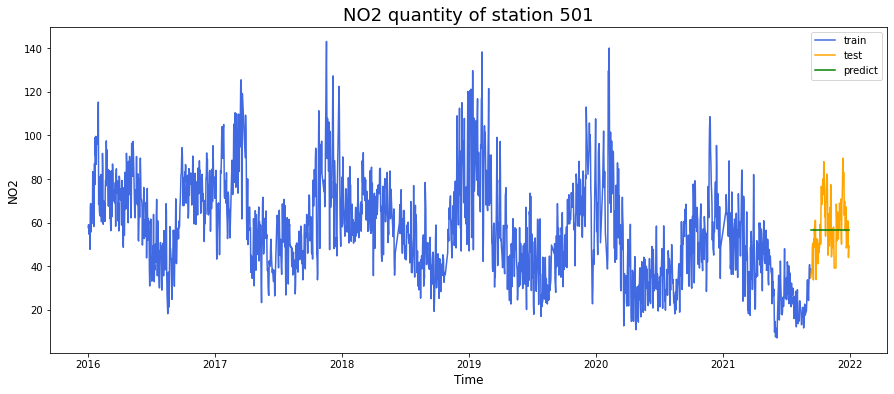

In [95]:
station_arima_graph(train, test, preds, 'NO2', '501')

In [96]:
# Manual Gridsearch
# p_list = [p for p in range(6,10)]
# d_list = [0, 1]
# q_list = [q for q in range(6,10)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/no2_arima_gridsearch.csv',index=False)

In [97]:
manual_grid = pd.read_csv('./saved_data/no2_arima_gridsearch.csv')

In [98]:
manual_grid.sort_values('mse').head()

,p,d,q,aic,mse
16,8.0,0.0,6.0,15382.837409,171.968557
24,9.0,0.0,6.0,15387.214844,173.317828
0,6.0,0.0,6.0,15384.586456,173.698826
27,9.0,0.0,9.0,15373.899422,174.402237
1,6.0,0.0,7.0,15383.276898,175.619961


In [99]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(8,0,6))
preds, aic, mse = fit_preds(ar1, test)

C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AIC: 15382.837408521322
MSE: 171.96855673365775


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


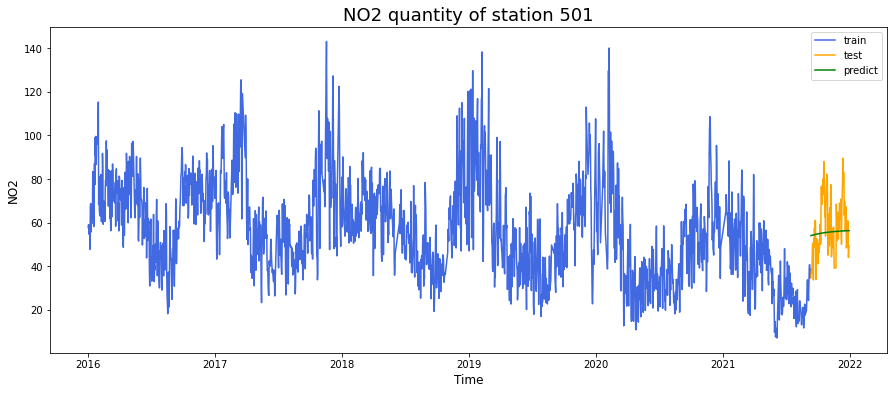

In [100]:
station_arima_graph(train, test, preds, 'NO2', '501')

ARIMA model can't capture trend of the series.

### RNN model

In [101]:
X_train, X_test, y_train, y_test = extract_split('no2', '501')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [102]:
# Design RNN
es = EarlyStopping(patience=3)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

In [103]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


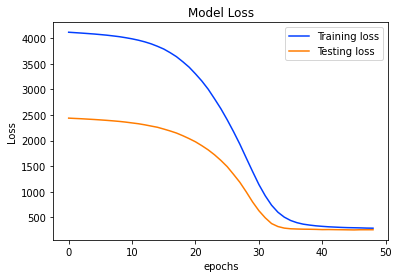

In [104]:
loss_graph()

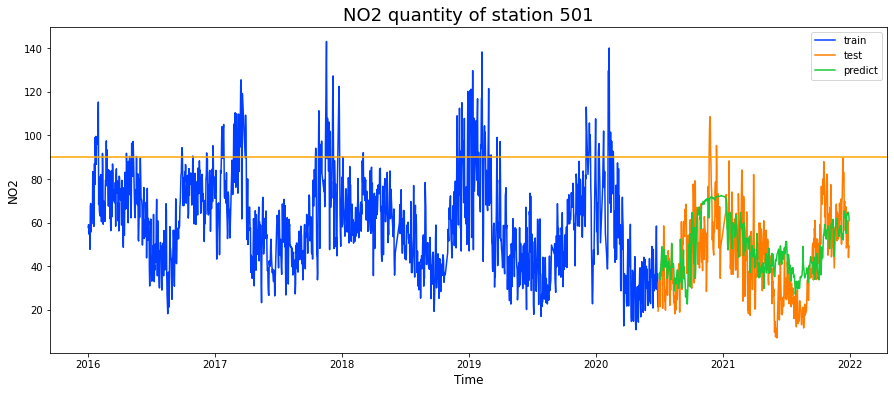

In [105]:
nn_result_graph('NO2', '501', 90, color='orange')

In [107]:
# Check amount of days that have no2 in air quality > 90
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
moderate_no2 = performance[performance['AQ_no2'] > 90].copy()
moderate_no2['pred_mod'] = (moderate_no2['pred'] > 90).astype(int)
moderate_no2.head()

,AQ_no2,pred,pred_mod
Time,,,
2020-11-23,92.45,62.193375,0
2020-11-24,103.00,69.855095,0
2020-11-25,108.60,70.971275,0
2020-11-26,107.70,71.349815,0
2020-11-27,92.83,71.618805,0


In [108]:
print(f"Predict NO2 > 90: {round(moderate_no2['pred_mod'].sum()/moderate_no2.shape[0]*100,2)}%")

Predict NO2 > 90: 0.0%


### LSTM model

In [109]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             100, es)

In [110]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


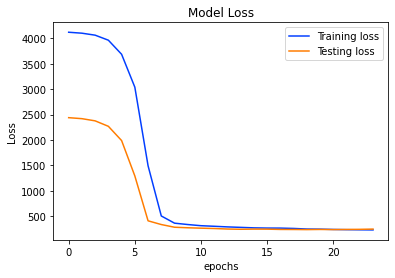

In [111]:
loss_graph()
model_error()

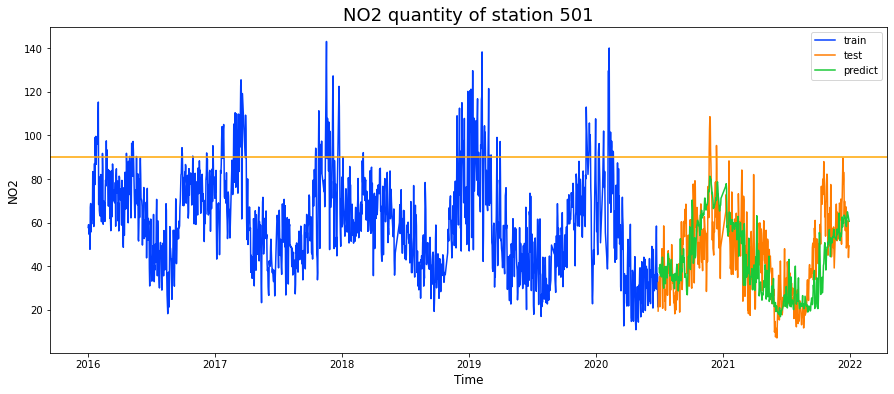

In [112]:
nn_result_graph('NO2', '501', aqi=90, color='orange')

In [114]:
# Check amount of days that have no2 in air quality > 90
performance = pd.DataFrame(y_test.iloc[3:])
performance['pred'] = y_preds
moderate_no2 = performance[performance['AQ_no2'] > 90].copy()
moderate_no2['pred_mod'] = (moderate_no2['pred'] > 90).astype(int)
moderate_no2.head()

,AQ_no2,pred,pred_mod
Time,,,
2020-11-23,92.45,74.123070,0
2020-11-24,103.00,79.287910,0
2020-11-25,108.60,81.284370,0
2020-11-26,107.70,80.998329,0
2020-11-27,92.83,79.789467,0


In [115]:
print(f"Predict NO2 > 90: {round(moderate_no2['pred_mod'].sum()/moderate_no2.shape[0]*100,2)}%")

Predict NO2 > 90: 0.0%


### LSTM model with feature engineering

In [446]:
data = extract_aq_df('no2','501')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_no2'] = data['AQ_no2'].rolling(window=12).mean()
data['rolling14_no2'] = data['AQ_no2'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_no2']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [447]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [460]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.01)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             100, es)

In [461]:
# 4. Predict
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


Training loss: 179.76
Testing loss: 228.24
MAPE: 34.21


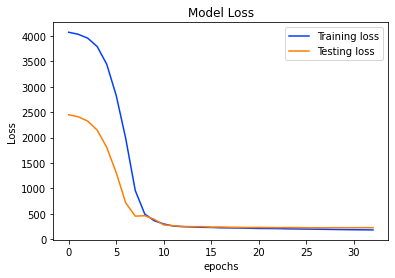

In [462]:
loss_graph()
model_error()

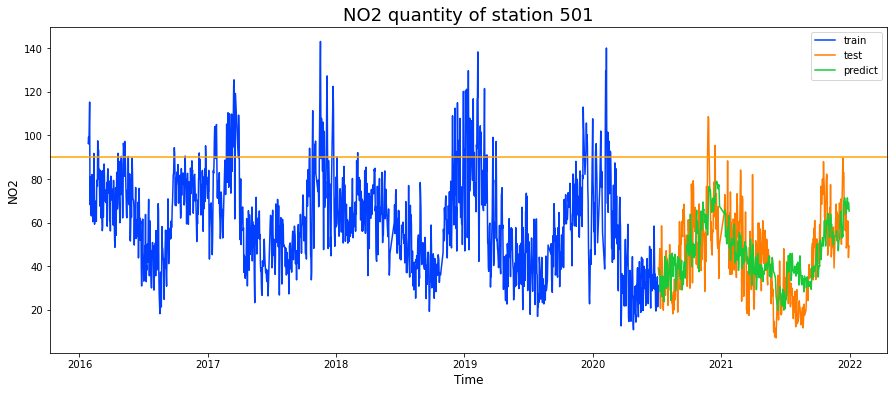

In [463]:
nn_result_graph('NO2', '501', aqi=90,color='orange')

### Summary model for air quality: NO$_{2}$
The days have NO$_{2}$ quantity > 90 (Moderate air quality):
- RNN model can predict NO$_{2}$ > 90 equal to 0%.
- LSTM model can predict NO$_{2}$ > 90 equal to 0%.
- Both RNN and LSTM model can't predict the peak value of the data but both RNN and LSTM are really good in capturing the trend of the data.

## Model for predicting ammonia (NH$_{3}$) quantity of station 626

### ARIMA model

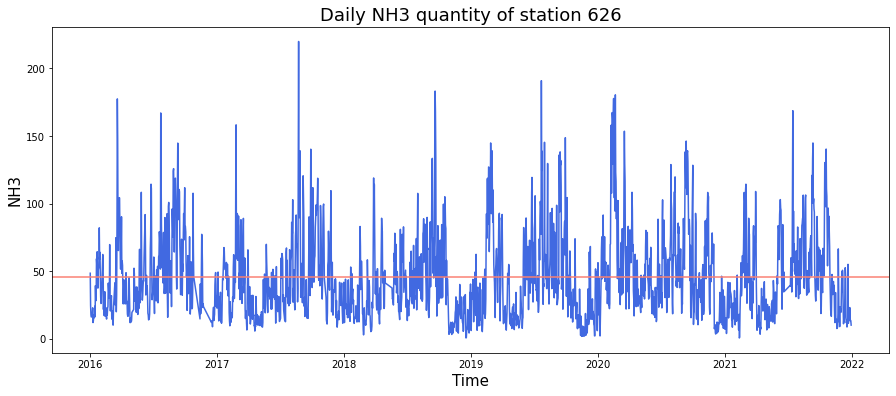

In [122]:
station_daily(station ='626',
              quality='nh3',
              label='NH3')

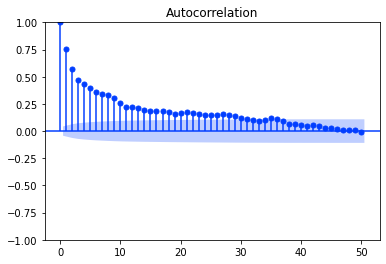

In [123]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('nh3','626')['AQ_nh3'],lags=50);

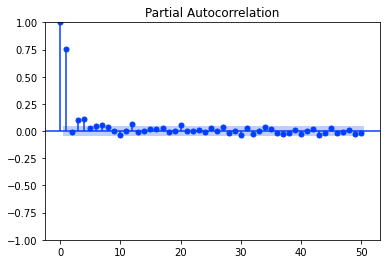

In [124]:
plot_pacf(extract_aq_df('nh3','626')['AQ_nh3'],lags=50,method='ywm');

In [125]:
# adfuller for checking the trend of station's 626 data
interpret_dftest(adfuller(extract_aq_df('nh3','626')['AQ_nh3'].dropna()))
# No trend

Test Statistic   -8.002906e+00
p-value           2.308297e-12
dtype: float64

In [126]:
train, test = train_test_time_series('626', 'nh3',test_size=0.05)
train.shape, test.shape

((1976,), (105,))

In [127]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [128]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 17638.603903284828
MSE: 926.3524393807932


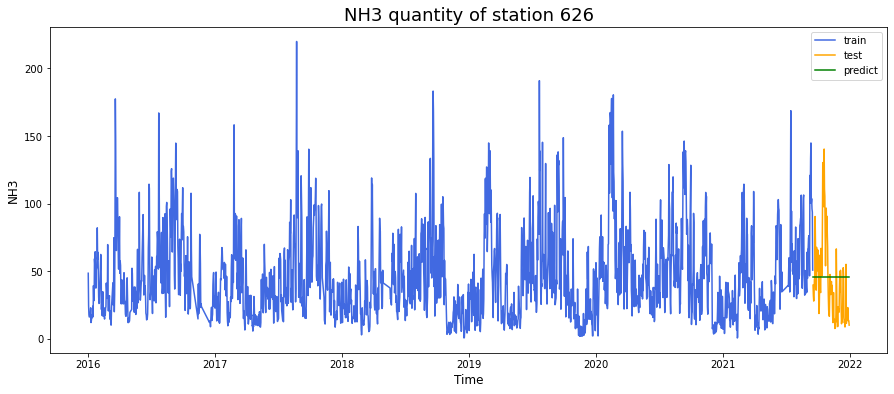

In [129]:
station_arima_graph(train, test, preds, 'NH3', '626')

In [130]:
# Manual Gridsearch
# p_list = [p for p in range(1,10)]
# d_list = [0, 1]
# q_list = [q for q in range(1,10)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/nh3_arima_gridsearch.csv',index=False)

In [131]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/nh3_arima_gridsearch.csv')

In [132]:
manual_grid.sort_values('aic').head()

,p,d,q,aic,mse
31,2.0,1.0,5.0,17582.021458,927.239198
12,1.0,1.0,4.0,17584.888375,927.726383
13,1.0,1.0,5.0,17586.901045,928.176502
154,9.0,1.0,2.0,17587.177698,927.202231
136,8.0,1.0,2.0,17588.513554,927.078812


### RNN Model

In [465]:
X_train, X_test, y_train, y_test = extract_split('nh3', '626')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [474]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(64, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

In [475]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 603.04
Testing loss: 924.31
MAPE: 130.74


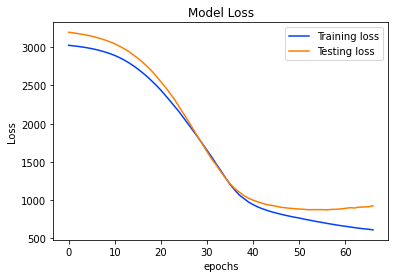

In [476]:
loss_graph()
model_error()

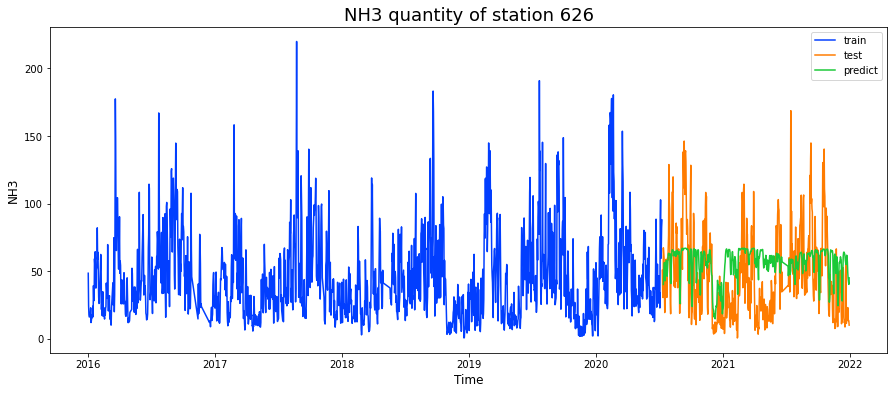

In [477]:
nn_result_graph('NH3', '626')

### LSTM model

In [482]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

Epoch 1/100
25/25 [==============================] - 4s 28ms/step - loss: 3036.9675 - val_loss: 3212.4170
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 3034.7808 - val_loss: 3209.5317
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 3032.4304 - val_loss: 3206.1343
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 3029.7188 - val_loss: 3202.2498
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 3026.3796 - val_loss: 3197.5149
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 3022.1687 - val_loss: 3191.8726
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 3017.0996 - val_loss: 3185.0823
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 3010.8301 - val_loss: 3177.1187
Epoch 9/100
25/25 [==============================] - 0s 5ms/step - loss: 3003.0842 - val_loss: 3167.4309
Epoch 10/100
25/25 [==============================] - 

In [483]:
# 4. Predict
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 704.25
Testing loss: 854.99
MAPE: 123.57


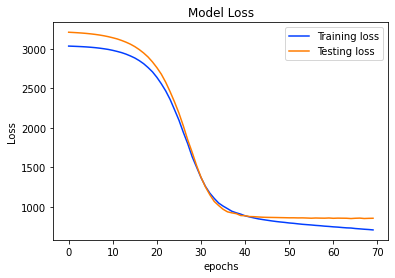

In [484]:
loss_graph()
model_error()

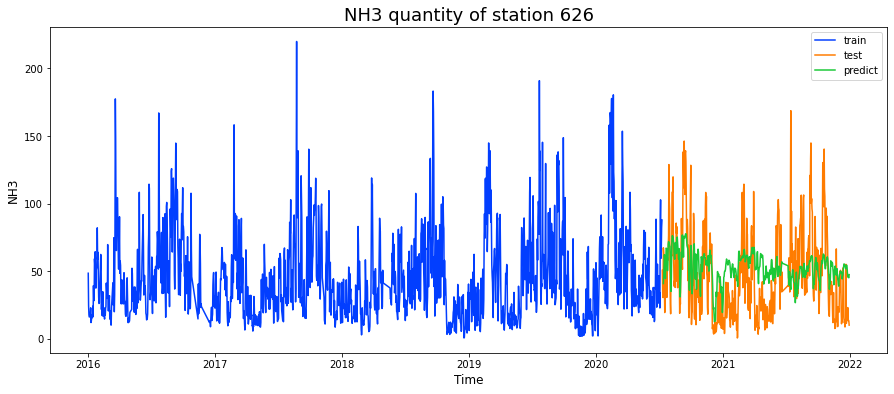

In [485]:
nn_result_graph('NH3', '626')

### LSTM model with feature engineering

In [487]:
data = extract_aq_df('nh3','626')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling12_nh3'] = data['AQ_nh3'].rolling(window=15).mean()
data['rolling26_nh3'] = data['AQ_nh3'].rolling(window=30).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_nh3']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [488]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [489]:
# Design LSTM
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

Epoch 1/100
24/24 [==============================] - 3s 32ms/step - loss: 3055.4832 - val_loss: 3221.0923
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 3052.8108 - val_loss: 3218.4255
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 3049.8396 - val_loss: 3215.2363
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 3046.2256 - val_loss: 3211.7766
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 3042.0046 - val_loss: 3207.6426
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 3036.9099 - val_loss: 3202.5811
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 3030.7034 - val_loss: 3196.5608
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 3023.0476 - val_loss: 3189.2300
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 3013.6838 - val_loss: 3180.4873
Epoch 10/100
24/24 [==============================] - 

In [490]:
# 4. Predict
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


Training loss: 607.74
Testing loss: 737.67
MAPE: 90.62


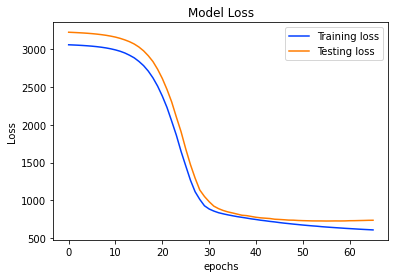

In [491]:
loss_graph()
model_error()

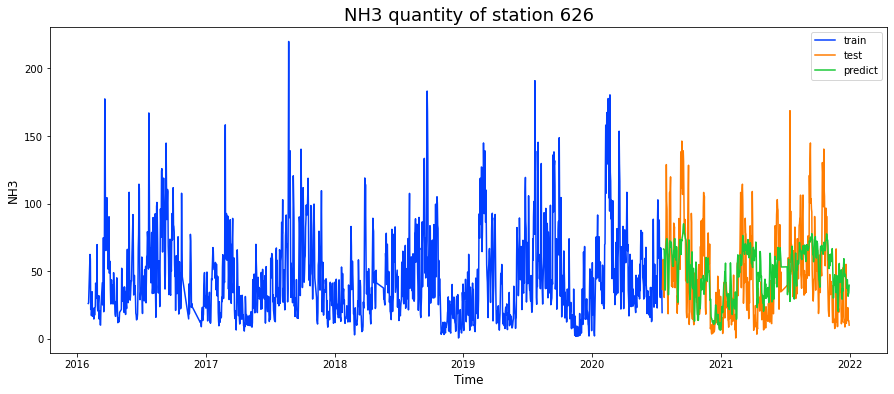

In [492]:
nn_result_graph('NH3', '626')

In [493]:
# model.save('./model/nh3_LSTM_feature_eng.h5')

## Model for predicting PM$_{10}$ of station 661

### ARIMA model

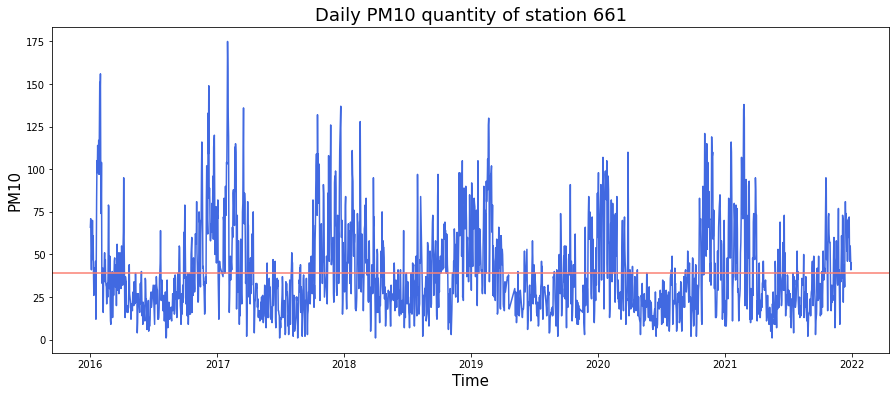

In [148]:
station_daily(station ='661',
              quality='pm10',
              label='PM10')

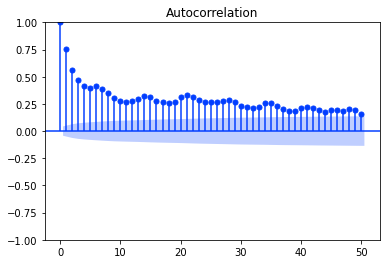

In [149]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('pm10','661')['AQ_pm10'],lags=50);

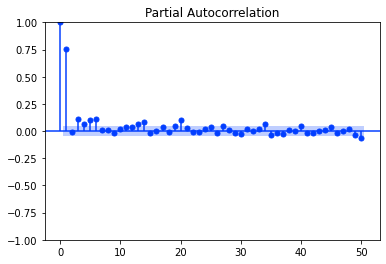

In [150]:
plot_pacf(extract_aq_df('pm10','661')['AQ_pm10'],lags=50,method='ywm');

In [151]:
# adfuller for checking the trend of station's 661 data
interpret_dftest(adfuller(extract_aq_df('pm10','661')['AQ_pm10'].dropna()))
# No trend

Test Statistic   -5.014854
p-value           0.000021
dtype: float64

In [152]:
train, test = train_test_time_series('661', 'pm10',test_size=0.05)
train.shape, test.shape

((1976,), (104,))

In [153]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [154]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 16857.709597079564
MSE: 376.90077558924753


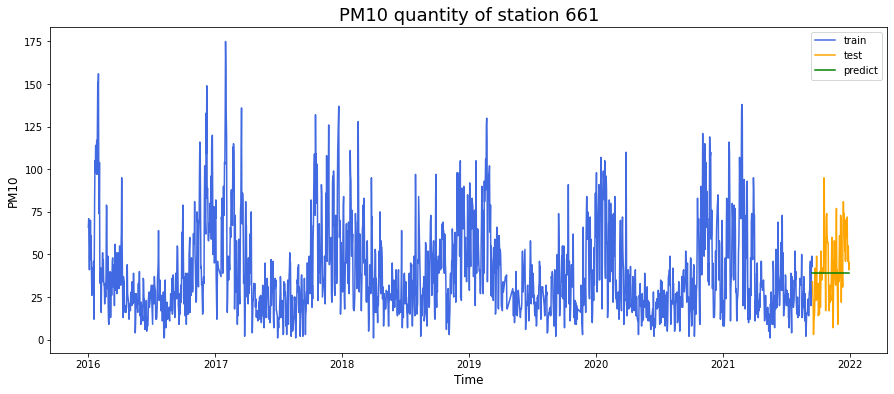

In [155]:
station_arima_graph(train, test, preds, 'PM10', '661')

In [156]:
# Manual Gridsearch
# p_list = [p for p in range(1,11)]
# d_list = [0, 1]
# q_list = [q for q in range(1,11)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/pm10_arima_gridsearch.csv',index=False)

In [157]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/pm10_arima_gridsearch.csv')

In [158]:
manual_grid.sort_values('aic').head()

,p,d,q,aic,mse
139,7.0,1.0,10.0,16730.217495,535.114448
199,10.0,1.0,10.0,16732.315462,531.225647
159,8.0,1.0,10.0,16735.072123,536.668627
118,6.0,1.0,9.0,16737.934705,530.820468
198,10.0,1.0,9.0,16738.711732,539.050847


In [159]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(7,1,10))
preds, aic, mse = fit_preds(ar1, test)

AIC: 16730.21749504151
MSE: 535.1144484772203


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


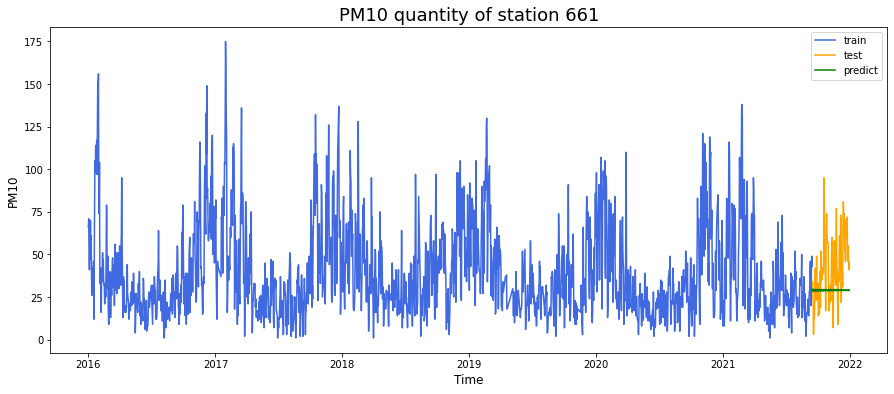

In [160]:
station_arima_graph(train, test, preds, 'PM10', '661')

### RNN Model

In [494]:
X_train, X_test, y_train, y_test = extract_split('pm10', '661')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [503]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             150, es)

In [504]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 288.93
Testing loss: 364.5
MAPE: 64.4


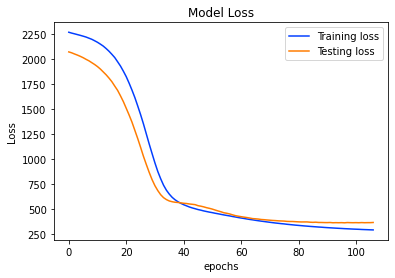

In [505]:
loss_graph()
model_error()

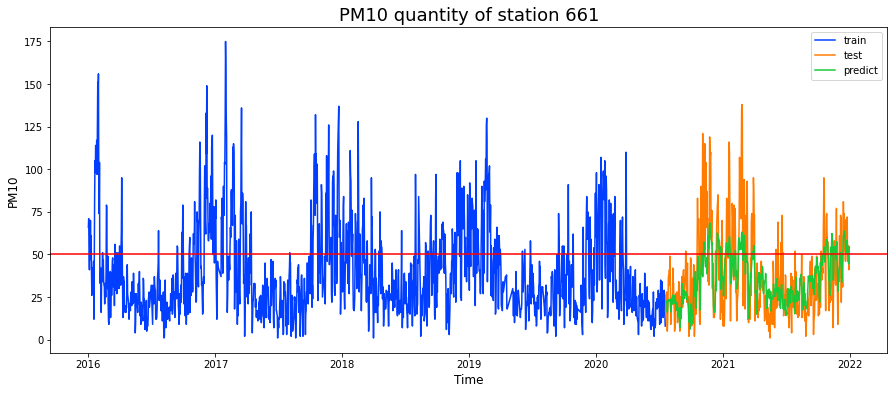

In [506]:
nn_result_graph('PM10', '661', aqi=50)

### LSTM model

In [533]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             150, es)

In [534]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 417.32
Testing loss: 444.12
MAPE: 90.54


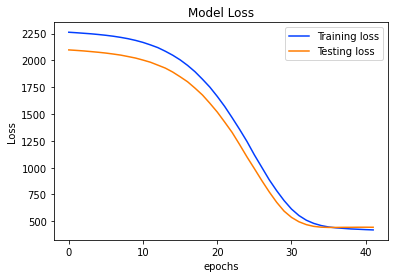

In [535]:
loss_graph()
model_error()

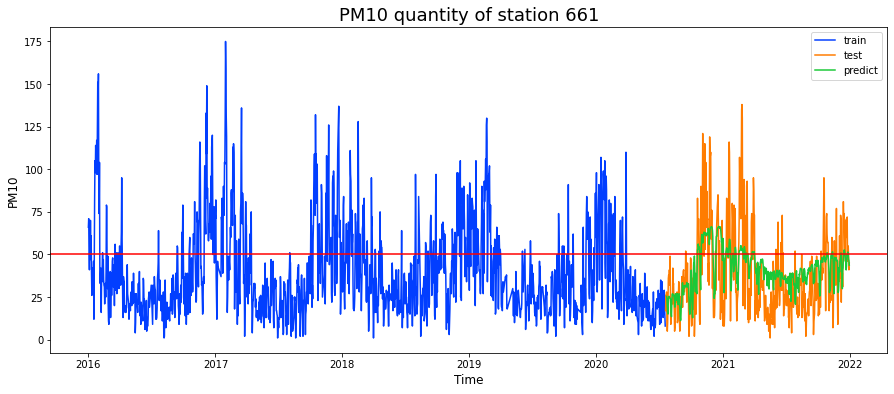

In [536]:
nn_result_graph('PM10', '661', aqi=50)

### LSTM model with feature engineering

In [538]:
data = extract_aq_df('pm10','661')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_pm10'] = data['AQ_pm10'].rolling(window=7).mean()
data['rolling15_pm10'] = data['AQ_pm10'].rolling(window=12).mean()
data['rolling30_pm10'] = data['AQ_pm10'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_pm10']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [539]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [544]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))


# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             100, es)

Epoch 1/100
25/25 [==============================] - 4s 29ms/step - loss: 2194.8826 - val_loss: 2119.3862
Epoch 2/100
25/25 [==============================] - 0s 5ms/step - loss: 2192.8596 - val_loss: 2117.8579
Epoch 3/100
25/25 [==============================] - 0s 5ms/step - loss: 2190.9585 - val_loss: 2116.1177
Epoch 4/100
25/25 [==============================] - 0s 5ms/step - loss: 2188.9722 - val_loss: 2114.2073
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 2186.9077 - val_loss: 2111.9585
Epoch 6/100
25/25 [==============================] - 0s 5ms/step - loss: 2184.5544 - val_loss: 2109.2874
Epoch 7/100
25/25 [==============================] - 0s 5ms/step - loss: 2181.8232 - val_loss: 2106.4492
Epoch 8/100
25/25 [==============================] - 0s 5ms/step - loss: 2178.7732 - val_loss: 2102.9617
Epoch 9/100
25/25 [==============================] - 0s 8ms/step - loss: 2175.2981 - val_loss: 2098.6438
Epoch 10/100
25/25 [==============================] - 

In [545]:
# 4. Prediction
y_preds = model.predict(test_sequences)

8/8 [==============================] - 1s 2ms/step


Training loss: 351.61
Testing loss: 365.11
MAPE: 61.03


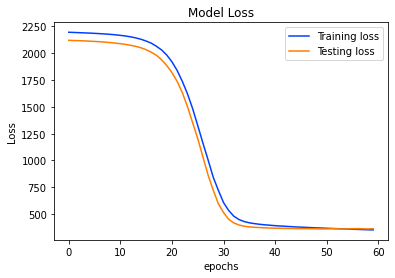

In [546]:
loss_graph()
model_error()

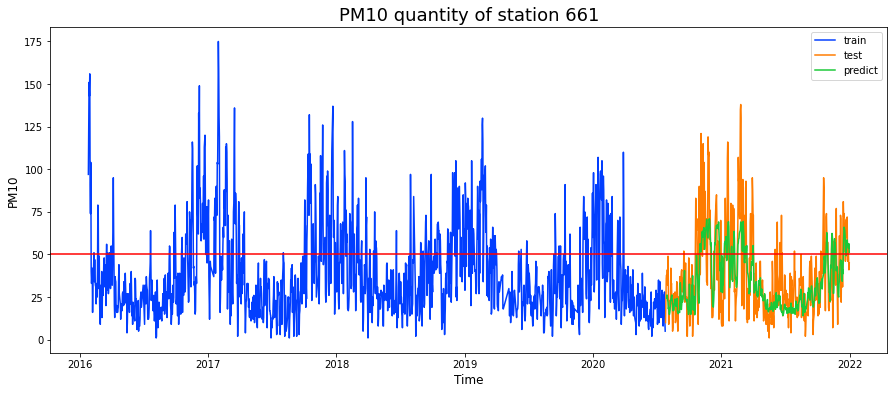

In [547]:
nn_result_graph('PM10', '661', aqi=50)

## Model for predicting PM$_{2.5}$ of station 1297

### ARIMA model

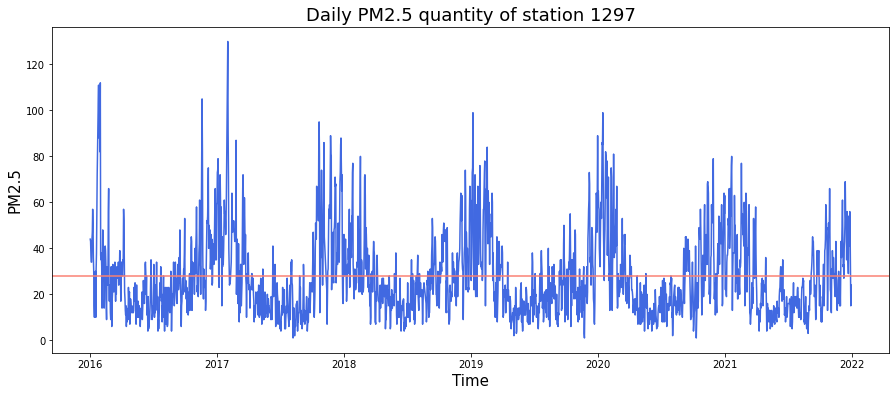

In [176]:
station_daily(station ='1297',
              quality='pm25',
              label='PM2.5')

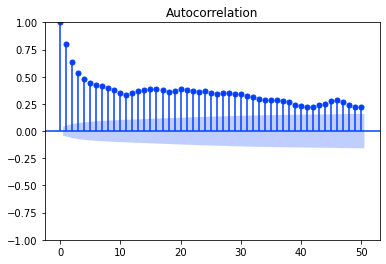

In [177]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('pm25','1297')['AQ_pm25'],lags=50);

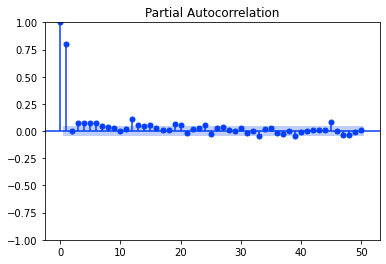

In [178]:
plot_pacf(extract_aq_df('pm25','1297')['AQ_pm25'],lags=50,method='ywm');

In [179]:
# adfuller for checking the trend of station's 1297 data
interpret_dftest(adfuller(extract_aq_df('pm25','1297')['AQ_pm25'].dropna()))
# No trend

Test Statistic   -4.131121
p-value           0.000860
dtype: float64

In [180]:
train, test = train_test_time_series('1297', 'pm25',test_size=0.05)
train.shape, test.shape

((2044,), (108,))

In [181]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [182]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 15589.541996871529
MSE: 213.66118797566762


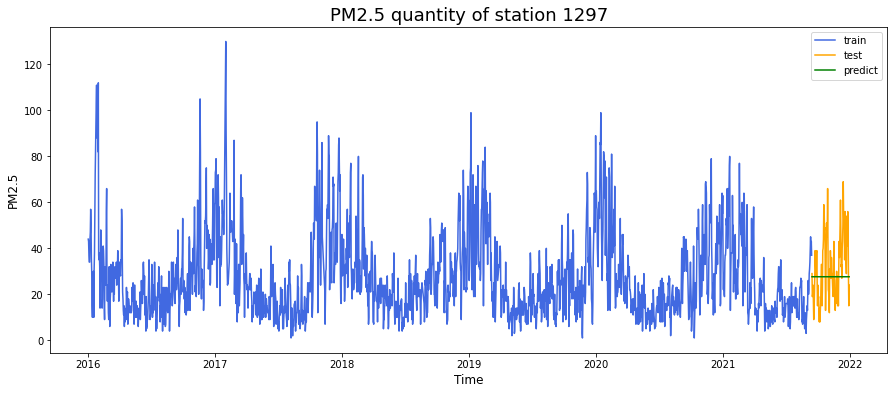

In [183]:
station_arima_graph(train, test, preds, 'PM2.5', '1297')

In [184]:
# Manual Gridsearch
# p_list = [p for p in range(1,11)]
# d_list = [0, 1]
# q_list = [q for q in range(1,11)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/pm25_arima_gridsearch.csv',index=False)

In [185]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/pm25_arima_gridsearch.csv')

In [186]:
manual_grid.sort_values('aic').head()

,p,d,q,aic,mse
79,4.0,1.0,10.0,15487.621117,241.540963
175,9.0,1.0,6.0,15490.344376,244.057467
89,5.0,0.0,10.0,15490.984165,218.458417
136,7.0,1.0,7.0,15491.202643,241.835549
156,8.0,1.0,7.0,15491.884511,241.304214


In [187]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(4,1,10))
preds, aic, mse = fit_preds(ar1, test)

AIC: 15487.621116967617
MSE: 241.5409630299658


C:\Users\Kant\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


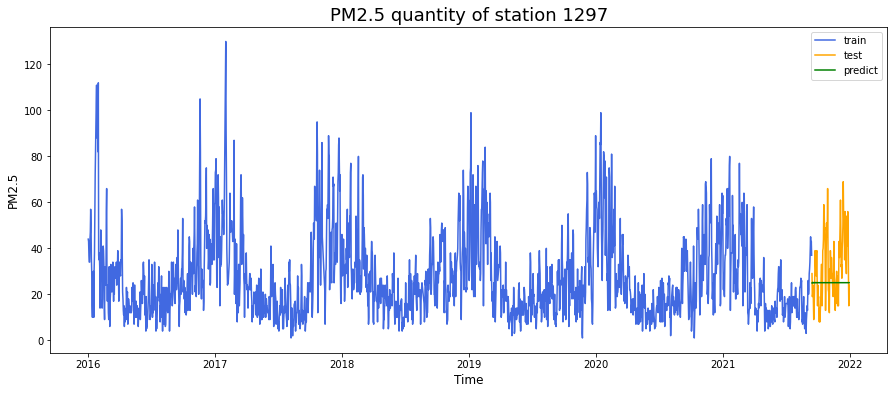

In [188]:
station_arima_graph(train, test, preds, 'PM2.5', '1297')

### RNN Model

In [549]:
X_train, X_test, y_train, y_test = extract_split('pm25', '1297')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [554]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             150, es)

In [555]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 97.93
Testing loss: 115.18
MAPE: 44.54


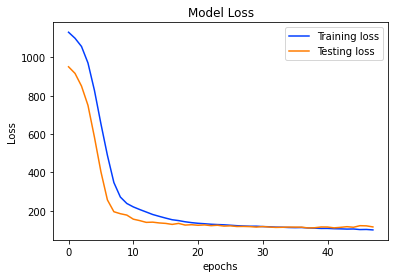

In [556]:
loss_graph()
model_error()

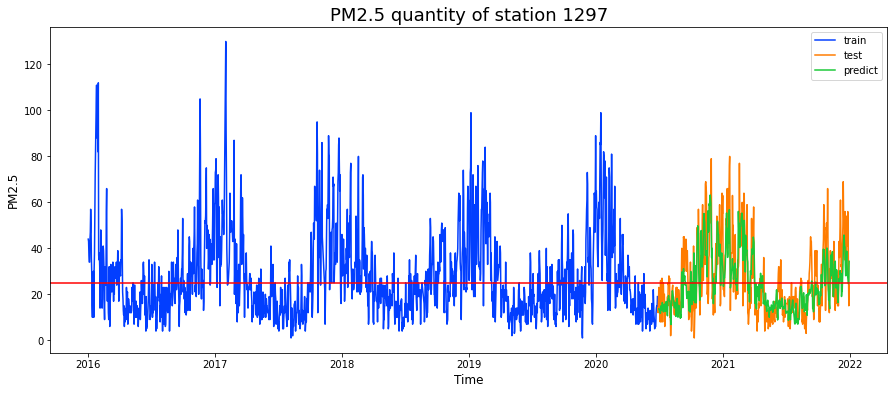

In [557]:
nn_result_graph('PM2.5', '1297', aqi=25)

### LSTM model

In [560]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='elu'))
model.add(Dense(32, activation='elu'))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.001, 
                             train_sequences, test_sequences,
                             150, es)

Epoch 1/150
26/26 [==============================] - 4s 35ms/step - loss: 1118.5265 - val_loss: 941.3425
Epoch 2/150
26/26 [==============================] - 0s 5ms/step - loss: 1015.2610 - val_loss: 756.7945
Epoch 3/150
26/26 [==============================] - 0s 5ms/step - loss: 596.1111 - val_loss: 273.6825
Epoch 4/150
26/26 [==============================] - 0s 5ms/step - loss: 260.1937 - val_loss: 152.2742
Epoch 5/150
26/26 [==============================] - 0s 6ms/step - loss: 190.7258 - val_loss: 131.7262
Epoch 6/150
26/26 [==============================] - 0s 6ms/step - loss: 180.6531 - val_loss: 128.2193
Epoch 7/150
26/26 [==============================] - 0s 5ms/step - loss: 161.1045 - val_loss: 118.0489
Epoch 8/150
26/26 [==============================] - 0s 5ms/step - loss: 151.1316 - val_loss: 117.1877
Epoch 9/150
26/26 [==============================] - 0s 5ms/step - loss: 141.8857 - val_loss: 117.0827
Epoch 10/150
26/26 [==============================] - 0s 9ms/step - lo

In [561]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 115.81
Testing loss: 116.27
MAPE: 51.6


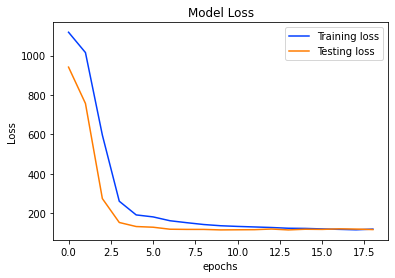

In [562]:
loss_graph()
model_error()

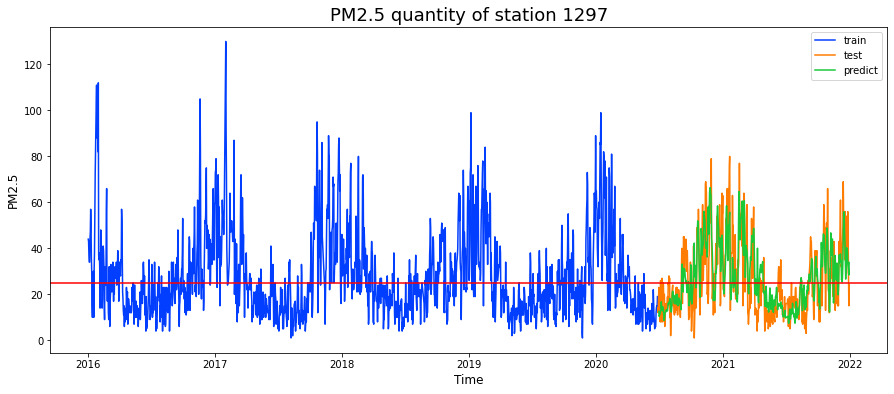

In [563]:
nn_result_graph('PM2.5', '1297', aqi=25)

### RNN model with feature engineering

In [565]:
data = extract_aq_df('pm25','1297')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling12_pm25'] = data['AQ_pm25'].rolling(window=12).mean()
data['rolling26_pm25'] = data['AQ_pm25'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_pm25']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [566]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [567]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.001)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0005, 
                             train_sequences, test_sequences,
                             150, es)

In [568]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 82.95
Testing loss: 115.16
MAPE: 49.19


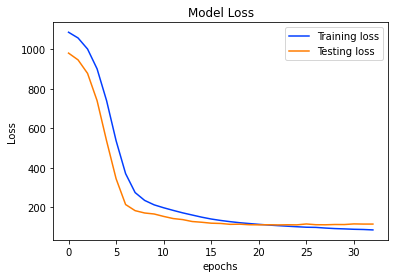

In [569]:
loss_graph()
model_error()

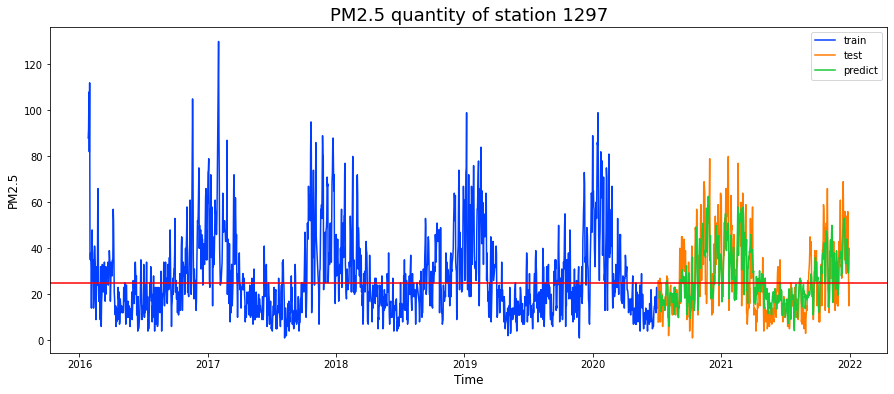

In [570]:
nn_result_graph('PM2.5', '1297', aqi=25)

In [571]:
# model.save('./model/pm25_RNN_feature_eng.h5')

## Model for predicting sulfur dioxide (SO$_{2}$) quantity of station STA.IT1509A

### ARIMA model

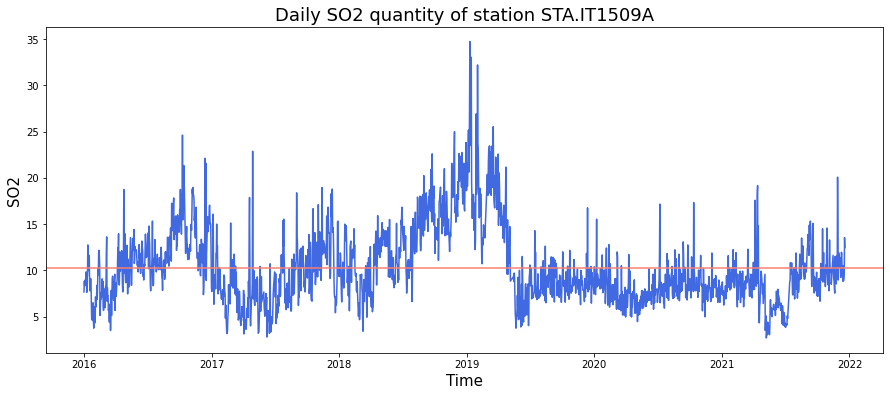

In [204]:
station_daily(station ='STA.IT1509A',
              quality='so2',
              label='SO2')

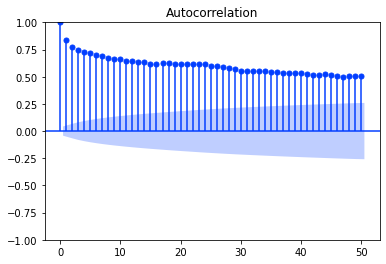

In [205]:
# Check seasonality by using acf and pacf
plot_acf(extract_aq_df('so2','STA.IT1509A')['AQ_so2'],lags=50);

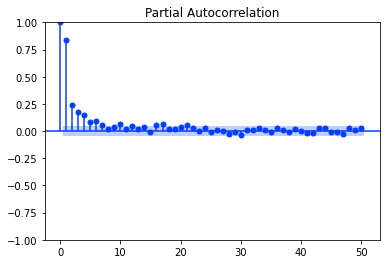

In [206]:
plot_pacf(extract_aq_df('so2','STA.IT1509A')['AQ_so2'],lags=50,method='ywm');

In [207]:
# adfuller for checking the trend of station's 1297 data
interpret_dftest(adfuller(extract_aq_df('so2','STA.IT1509A')['AQ_so2'].dropna()))
# No trend

Test Statistic   -2.962513
p-value           0.038547
dtype: float64

In [208]:
train, test = train_test_time_series('STA.IT1509A', 'so2',test_size=0.05)
train.shape, test.shape

((2017,), (107,))

In [209]:
# Fix index of testing set
idx = pd.period_range(test.index[0],test.index[-1])
test = test.reindex(idx,method='ffill')

In [210]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(1,0,0))
preds, aic, mse = fit_preds(ar1, test)

AIC: 8957.690156665445
MSE: 4.646300519305903


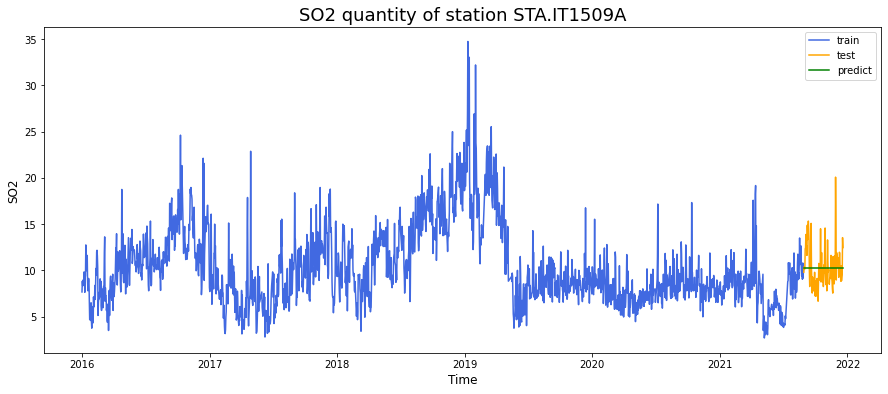

In [211]:
station_arima_graph(train, test, preds, 'SO2', 'STA.IT1509A')

In [212]:
# Manual Gridsearch
# p_list = [p for p in range(1,11)]
# d_list = [0, 1]
# q_list = [q for q in range(1,11)]
# manual_grid = manual_gridsearch(p_list, d_list, q_list)
# manual_grid.to_csv('./saved_data/so2_arima_gridsearch.csv',index=False)

In [213]:
# For saving time manual gridsearch of ARIMA model
# We load csv instead of refitting the model
manual_grid = pd.read_csv('./saved_data/so2_arima_gridsearch.csv')

In [214]:
manual_grid.sort_values('aic').head()

,p,d,q,aic,mse
70,4.0,1.0,1.0,8666.651503,4.783025
13,1.0,1.0,4.0,8666.944011,4.885364
12,1.0,1.0,3.0,8667.487907,4.799338
112,6.0,1.0,3.0,8667.739036,4.857183
14,1.0,1.0,5.0,8667.797577,4.853499


In [215]:
# Fit model ARIMA
ar1 = ARIMA(endog=train, order=(4,1,1))
preds, aic, mse = fit_preds(ar1, test)

AIC: 8666.651502637309
MSE: 4.7830245846081425


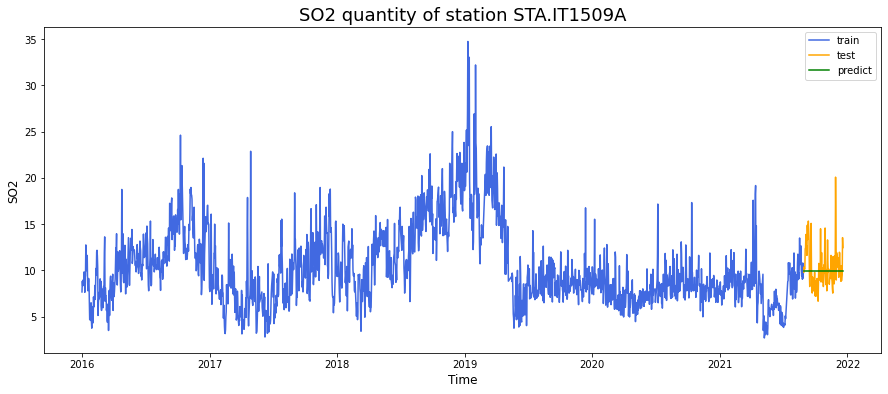

In [216]:
station_arima_graph(train, test, preds, 'SO2', 'STA.IT1509A')

### RNN Model

In [572]:
X_train, X_test, y_train, y_test = extract_split('so2', 'STA.IT1509A')
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [573]:
# Design RNN
es = EarlyStopping(patience=10)
# 1. structure/topology
model = Sequential()
model.add(GRU(32, input_shape=input_shape, return_sequences=True))
model.add(GRU(32, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.01)))


# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.0001, 
                             train_sequences, test_sequences,
                             150, es)

In [574]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 14.92
Testing loss: 9.81
MAPE: 24.99


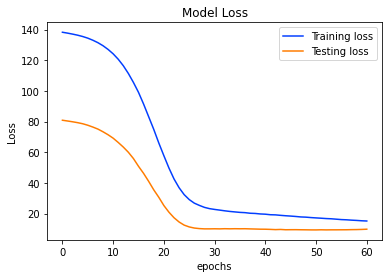

In [575]:
loss_graph()
model_error()

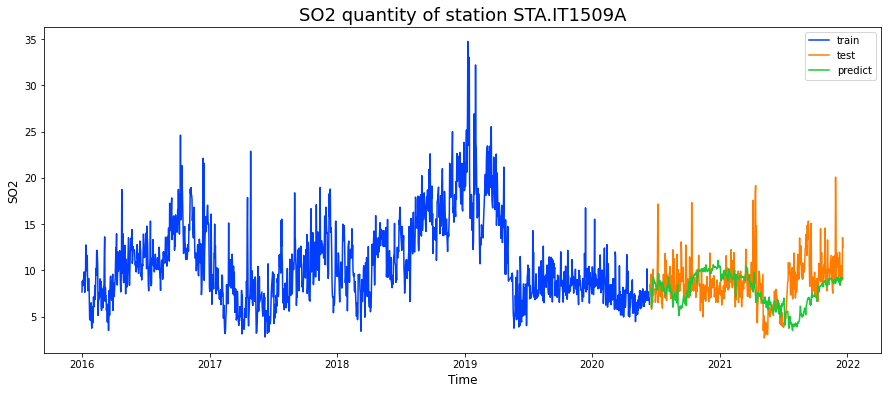

In [576]:
nn_result_graph('SO2', 'STA.IT1509A')

### LSTM model

In [323]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(LSTM(16, return_sequences=False,kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.1)))
model.add(Dense(16, activation='relu',kernel_regularizer=l2(0.1)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.1)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.00005, 
                             train_sequences, test_sequences,
                             150, es)

Epoch 1/150
25/25 [==============================] - 3s 32ms/step - loss: 146.2970 - val_loss: 88.4942
Epoch 2/150
25/25 [==============================] - 0s 7ms/step - loss: 145.7519 - val_loss: 88.1218
Epoch 3/150
25/25 [==============================] - 0s 7ms/step - loss: 145.2125 - val_loss: 87.7467
Epoch 4/150
25/25 [==============================] - 0s 7ms/step - loss: 144.7018 - val_loss: 87.3707
Epoch 5/150
25/25 [==============================] - 0s 7ms/step - loss: 144.1868 - val_loss: 87.0185
Epoch 6/150
25/25 [==============================] - 0s 9ms/step - loss: 143.6839 - val_loss: 86.6640
Epoch 7/150
25/25 [==============================] - 0s 8ms/step - loss: 143.1787 - val_loss: 86.3118
Epoch 8/150
25/25 [==============================] - 0s 7ms/step - loss: 142.6796 - val_loss: 85.9831
Epoch 9/150
25/25 [==============================] - 0s 7ms/step - loss: 142.1837 - val_loss: 85.6404
Epoch 10/150
25/25 [==============================] - 0s 7ms/step - loss: 141.689

In [324]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 3ms/step


Training loss: 24.7
Testing loss: 14.65
MAPE: 27.95


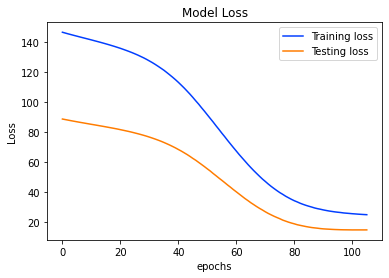

In [325]:
loss_graph()
model_error()

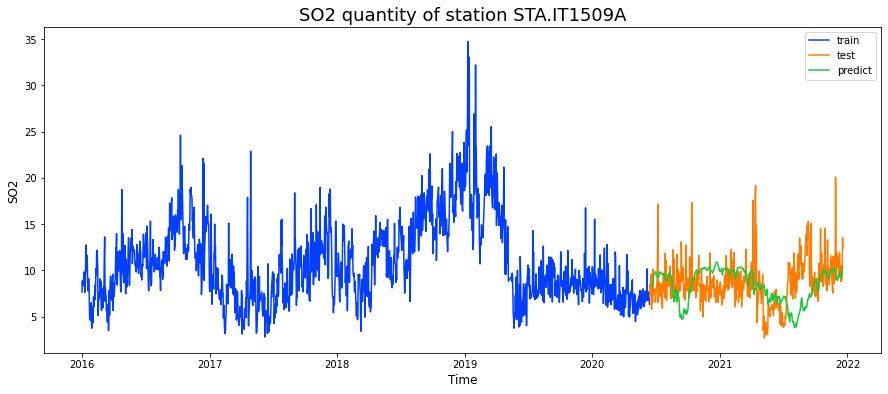

In [326]:
nn_result_graph('SO2', 'STA.IT1509A')

### LSTM model with feature engineering

In [301]:
data = extract_aq_df('so2','STA.IT1509A')
drop_cols = ['IDStations','Latitude', 'Longitude', 'Altitude', 'AQ_pm10', 'AQ_pm25', 'AQ_co','AQ_nh3',\
 'AQ_nox','AQ_no2','AQ_so2']

# Additional of rolling average
data['rolling7_so2'] = data['AQ_so2'].rolling(window=7).mean()
data['rolling15_so2'] = data['AQ_so2'].rolling(window=12).mean()
data['rolling30_so2'] = data['AQ_so2'].rolling(window=26).mean()
data['day_of_year'] = data.index.day_of_year
data['day_of_week'] = data.index.day_of_week
data = data.dropna()

X = data.drop(columns=drop_cols)
# get dummies of categorical columns
X = pd.get_dummies(X,columns=['WE_mode_wind_direction_10m', 'WE_mode_wind_direction_100m'])
y = data[f'AQ_so2']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=False)

In [302]:
train_sequences, test_sequences, input_shape = scale_sequences(X_train, X_test,
                                                               y_train, y_test, 
                                                               length=3)

In [303]:
# Design LSTM
es = EarlyStopping(patience=5)
# 1. structure/topology
model = Sequential()
model.add(LSTM(16, input_shape=input_shape, return_sequences=True))
model.add(LSTM(16, return_sequences=False,kernel_regularizer=l2(0.1)))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.1)))
model.add(Dense(32, activation='elu',kernel_regularizer=l2(0.1)))
model.add(Dense(16, activation='elu',kernel_regularizer=l2(0.1)))

# Outer layer - what activation would be appropiate
model.add(Dense(1, activation=None))

# 2,3. Compile and fit using function .compile_fit()
model, history = compile_fit(model, 0.00005, 
                             train_sequences, test_sequences,
                             150, es)

In [304]:
# 4. Prediction
y_preds = model.predict(test_sequences)

9/9 [==============================] - 1s 2ms/step


Training loss: 13.6
Testing loss: 12.43
MAPE: 20.76


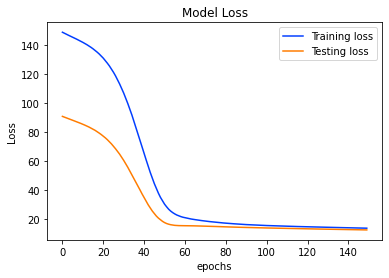

In [305]:
loss_graph()
model_error()

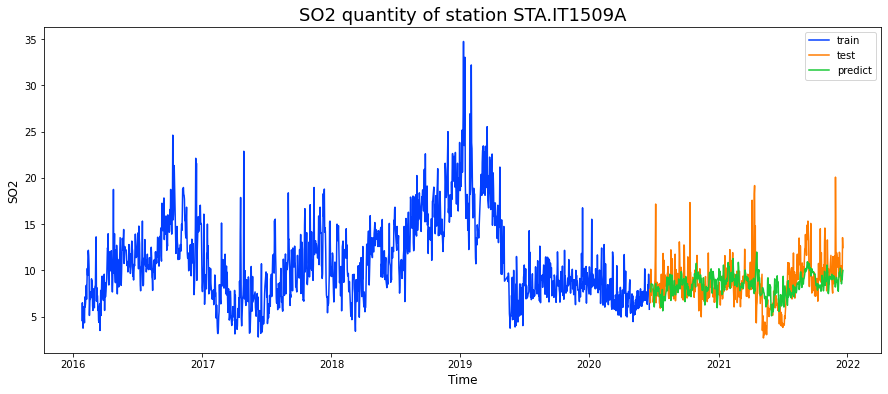

In [306]:
nn_result_graph('SO2', 'STA.IT1509A')

# Conclusion
---

# Recommendation
---